# 텍스트 분류- 뉴스
- 자연어 처리 + RNN

In [144]:
# 모듈 로딩
from sklearn.datasets import fetch_20newsgroups
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, SimpleRNN, LSTM, GRU, Embedding, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import set_random_seed, pad_sequences, to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import nltk
import konlpy

In [4]:
group = fetch_20newsgroups(subset='all', remove=('footers', 'headers'))

In [7]:
group.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [8]:
data = group['data']
target = group['target']
target_names = group['target_names']

In [9]:
# print(f"data: {data}")
# print(f"target: {target}")
print(f"target_names: {target_names}")
print(f"target_names 수: {len(target_names)}")

target_names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
target_names 수: 20


## NLP 자연어처리
1. 자연어 -> 단어사전
2. 단어사전 -> 수치화
3. 패딩으로 길이 동일하게 조정

### 1. 자연어 -> 단어사전

In [14]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [53]:
from nltk import word_tokenize, sent_tokenize
sw = nltk.corpus.stopwords.words("english")
total_token = []
for j in data:
    total_token.append([i for i in word_tokenize(j) if i not in sw])
print(len(total_token))

18846


### 2. 단어사전 -> 수치화

In [54]:
len(total_token)

18846

In [126]:
tk = Tokenizer(num_words=7000, oov_token=1)  # num_words=7000, oov_token='oov'
tk.fit_on_texts(total_token)
# print(tk.word_index)
# print(tk.word_counts)
# 문장에서 생성된 사전(voca)을 기반으로 수치화
# print(tk.texts_to_sequences(total_token))
token_num = np.array(tk.texts_to_sequences(total_token))
print(token_num[0])
print(token_num.max())

[8, 141, 1, 2310, 1156, 354, 2807, 1082, 307, 1159, 987, 2310, 2321, 3004, 4, 189, 3, 8, 241, 1, 241, 1, 4, 166, 3, 8, 109, 185, 267, 1, 29, 3490, 241, 6489, 2310, 4, 299, 3, 1242, 3004, 1049, 8, 276, 4, 4462, 1699, 66, 121, 1198, 604, 1787, 4, 94, 48, 193, 1, 1657, 1042, 1905, 4, 6575, 152, 4462, 193, 1657, 277, 480, 350, 97, 2310, 109, 1724, 1, 3446, 458, 4, 8, 1, 65, 2955, 1612, 953, 1198, 604, 188, 4, 2310, 1089, 17, 17, 17]
[6941, 1, 1782, 1988, 62, 585, 267, 1, 1761, 130, 615, 17, 1, 18, 470, 9, 7, 1, 6, 1, 107, 548, 340, 400, 9, 548, 1, 4, 2205]


C:\Users\User\AppData\Local\Temp\ipykernel_1100\349335917.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_num = np.array(tk.texts_to_sequences(total_token))


In [127]:
print(len(tk.word_counts))

213450


In [102]:
a = []
for val in tk.word_counts.values():
    if val > 50 :
        a.append(val)
print(len(a))


6899


In [ ]:
np.median([val for val in tk.word_counts.values()])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfvector = TfidfVectorizer()
tfvector.fit(data)
data_t = tfvector.transform(data)

## 값 분포 확인

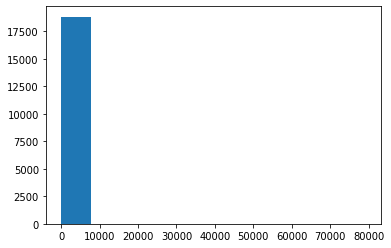

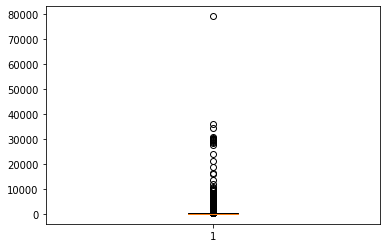

In [128]:
plt.hist([len(i) for i in token_num])
plt.show()
plt.boxplot([len(i) for i in token_num])
plt.show()

In [129]:
np.median([len(i) for i in token_num])

121.0

## 패딩

In [130]:
token_num = pad_sequences(token_num, maxlen=200)
print(len(token_num))

18846


## 데이터 분리 (train, val, test)

In [131]:
x_train, x_test, y_train, y_test = train_test_split(token_num, target, stratify=target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [132]:
print(x_train.shape, y_train.shape)

(12060, 200) (12060,)


## 타겟 값 범주화

In [133]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## 모델 구성

In [62]:
# 모델 구성
md = Sequential()
md.add(Embedding(7000, 20, input_length=100))  
md.add(SimpleRNN(units=10))
md.add(Dense(20, activation='softmax'))
md.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 20)           10000     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 20)                220       
                                                                 
Total params: 10,530
Trainable params: 10,530
Non-trainable params: 0
_________________________________________________________________


In [41]:
plot_model(md)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [63]:
# 모델 생성 및 학습
md.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model_rmsprop.h5', monitor='val_loss', save_best_only=True)
history = md.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, mcp])

Epoch 1/100
377/377 [==============================] - 6s 14ms/step - loss: 2.8770 - accuracy: 0.0833 - val_loss: 2.7574 - val_accuracy: 0.0971
Epoch 2/100
377/377 [==============================] - 5s 14ms/step - loss: 2.7250 - accuracy: 0.1039 - val_loss: 2.7038 - val_accuracy: 0.1005
Epoch 3/100
377/377 [==============================] - 5s 13ms/step - loss: 2.6609 - accuracy: 0.1260 - val_loss: 2.6692 - val_accuracy: 0.1154
Epoch 4/100
377/377 [==============================] - 5s 14ms/step - loss: 2.6271 - accuracy: 0.1372 - val_loss: 2.6659 - val_accuracy: 0.1121
Epoch 5/100
377/377 [==============================] - 6s 15ms/step - loss: 2.5909 - accuracy: 0.1456 - val_loss: 2.6102 - val_accuracy: 0.1174
Epoch 6/100
377/377 [==============================] - 5s 14ms/step - loss: 2.5598 - accuracy: 0.1538 - val_loss: 2.5962 - val_accuracy: 0.1240
Epoch 7/100
377/377 [==============================] - 5s 14ms/step - loss: 2.5365 - accuracy: 0.1671 - val_loss: 2.6527 - val_accuracy:

In [64]:
# 모델 평가
md.evaluate(x_test, y_test)

118/118 [==============================] - 0s 4ms/step - loss: 2.5724 - accuracy: 0.1568


[2.5723774433135986, 0.1567639261484146]

## 모델 LSTM

In [141]:
# 모델 구성
md2 = Sequential()
md2.add(Embedding(7000, 1000, input_length=200))  
md2.add(LSTM(units=10, dropout=0.3, recurrent_dropout=0.3))
md2.add(Dense(20, activation='softmax'))
md2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 1000)         7000000   
                                                                 
 lstm_6 (LSTM)               (None, 10)                40440     
                                                                 
 dense_12 (Dense)            (None, 20)                220       
                                                                 
Total params: 7,040,660
Trainable params: 7,040,660
Non-trainable params: 0
_________________________________________________________________


In [142]:
# 모델 생성 및 학습
md2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model_lstm_dropout2.h5', monitor='val_loss', save_best_only=True)
history = md2.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, mcp])

Epoch 1/100
377/377 [==============================] - 231s 607ms/step - loss: 2.7671 - accuracy: 0.1496 - val_loss: 2.6110 - val_accuracy: 0.2023
Epoch 2/100
377/377 [==============================] - 233s 617ms/step - loss: 2.2741 - accuracy: 0.2963 - val_loss: 2.3010 - val_accuracy: 0.3017
Epoch 3/100
377/377 [==============================] - 229s 608ms/step - loss: 1.8446 - accuracy: 0.4743 - val_loss: 1.8154 - val_accuracy: 0.4708
Epoch 4/100
377/377 [==============================] - 224s 595ms/step - loss: 1.4013 - accuracy: 0.6267 - val_loss: 1.4904 - val_accuracy: 0.5945
Epoch 5/100
377/377 [==============================] - 223s 592ms/step - loss: 1.0380 - accuracy: 0.7402 - val_loss: 1.2674 - val_accuracy: 0.6645
Epoch 6/100
377/377 [==============================] - 223s 592ms/step - loss: 0.7571 - accuracy: 0.8154 - val_loss: 1.1022 - val_accuracy: 0.6989
Epoch 7/100
377/377 [==============================] - 221s 587ms/step - loss: 0.5629 - accuracy: 0.8663 - val_loss: 1

In [143]:
# 모델 평가
md2.evaluate(x_test, y_test)

118/118 [==============================] - 8s 65ms/step - loss: 1.2133 - accuracy: 0.7273


[1.2132810354232788, 0.7273209691047668]

## 모델 GRU

In [97]:
# 모델 구성
md3 = Sequential()
md3.add(Embedding(4000, 2000, input_length=200))  
md3.add(GRU(units=10))
md3.add(Dense(20, activation='softmax'))
md3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 2000)         8000000   
                                                                 
 gru_1 (GRU)                 (None, 10)                60360     
                                                                 
 dense_8 (Dense)             (None, 20)                220       
                                                                 
Total params: 8,060,580
Trainable params: 8,060,580
Non-trainable params: 0
_________________________________________________________________


In [98]:
# 모델 생성 및 학습
md3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model_gru.h5', monitor='val_loss', save_best_only=True)
history = md3.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, mcp])

Epoch 1/100
377/377 [==============================] - 91s 236ms/step - loss: 2.6328 - accuracy: 0.2096 - val_loss: 2.1156 - val_accuracy: 0.3853
Epoch 2/100
377/377 [==============================] - 91s 242ms/step - loss: 1.7079 - accuracy: 0.5539 - val_loss: 1.6092 - val_accuracy: 0.5653
Epoch 3/100
377/377 [==============================] - 92s 244ms/step - loss: 1.2446 - accuracy: 0.6766 - val_loss: 1.4626 - val_accuracy: 0.5796
Epoch 4/100
377/377 [==============================] - 91s 241ms/step - loss: 0.9786 - accuracy: 0.7457 - val_loss: 1.4171 - val_accuracy: 0.5872
Epoch 5/100
377/377 [==============================] - 95s 252ms/step - loss: 0.7955 - accuracy: 0.7968 - val_loss: 1.4169 - val_accuracy: 0.5822
Epoch 6/100
377/377 [==============================] - 90s 240ms/step - loss: 0.6567 - accuracy: 0.8347 - val_loss: 1.4515 - val_accuracy: 0.5832
Epoch 7/100
377/377 [==============================] - 91s 242ms/step - loss: 0.5641 - accuracy: 0.8557 - val_loss: 1.5061 -

In [99]:
# 모델 평가
md3.evaluate(x_test, y_test)

118/118 [==============================] - 6s 51ms/step - loss: 1.8148 - accuracy: 0.5844


[1.8148125410079956, 0.5843501091003418]

## 양방향 RNN 적용
- Bidirectional 함수 적용

In [145]:
# 모델 구성
md4 = Sequential()
md4.add(Embedding(7000, 1000, input_length=200))  
md4.add(Bidirectional(LSTM(units=10, dropout=0.3)) )
md4.add(Dense(20, activation='softmax'))
md4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 200, 1000)         7000000   
                                                                 
 bidirectional (Bidirectiona  (None, 20)               80880     
 l)                                                              
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
Total params: 7,081,300
Trainable params: 7,081,300
Non-trainable params: 0
_________________________________________________________________


In [146]:
# 모델 생성 및 학습
md4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model_gru.h5', monitor='val_loss', save_best_only=True)
history = md4.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, mcp])

Epoch 1/100
377/377 [==============================] - 165s 430ms/step - loss: 2.7479 - accuracy: 0.1498 - val_loss: 2.4233 - val_accuracy: 0.2344
Epoch 2/100
377/377 [==============================] - 166s 440ms/step - loss: 2.0977 - accuracy: 0.3616 - val_loss: 1.9843 - val_accuracy: 0.3969
Epoch 3/100
377/377 [==============================] - 164s 436ms/step - loss: 1.5510 - accuracy: 0.5552 - val_loss: 1.6400 - val_accuracy: 0.5056
Epoch 4/100
377/377 [==============================] - 165s 439ms/step - loss: 1.1105 - accuracy: 0.7075 - val_loss: 1.4309 - val_accuracy: 0.5836
Epoch 5/100
377/377 [==============================] - 168s 446ms/step - loss: 0.8038 - accuracy: 0.7973 - val_loss: 1.3675 - val_accuracy: 0.6028
Epoch 6/100
377/377 [==============================] - 167s 443ms/step - loss: 0.5374 - accuracy: 0.8683 - val_loss: 1.0780 - val_accuracy: 0.6837
Epoch 7/100
377/377 [==============================] - 168s 445ms/step - loss: 0.3001 - accuracy: 0.9252 - val_loss: 1

KeyboardInterrupt: 

#### test 점수 : 
- best_model_lstm_dropout.h5 -> 0.7011 현재 2등
- best_model_lstm_dropout2.h5 -> 0.7273 현재 1등